# Correlation Grid

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import pearsonr
from tqdm import tqdm
from smoothing import smooth_temp_solar
from plot_map import plot_map
from settings import path_data, path_results

In [2]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')
ds_temp_r2 = xr.open_dataset(path_data / 'T2m_R2_ym_1stMill.nc')

In [3]:
aod = ds_volc['AOD'].values.flatten()
temp, solar = smooth_temp_solar(ds_temp_r1['T2m'].values, ds_solar['TSI'].values.flatten())

In [4]:
def grid_pearson(n_splits, target_values):
    lon = ds_temp_r1['lon'].values
    lat = ds_temp_r1['lat'].values

    # Group long and lat values together
    lat_labels = np.digitize(lat, np.linspace(np.min(lat), np.max(lat), n_splits, endpoint=False))
    lon_labels = np.digitize(lon, np.linspace(np.min(lon), np.max(lon), n_splits, endpoint=False))

    lons_mat, lats_mat = np.meshgrid(lon_labels, lat_labels)
    pearson_grid = np.zeros((96, 192))

    # Calculate the Pearson for each cell
    for c1 in np.unique(lat_labels):
        for c2 in np.unique(lon_labels):
            cell = (lons_mat == c2) & (lats_mat == c1)
            temps = np.mean(ds_temp_r1['T2m'].values[:, cell], axis=1)
            pearson_grid[cell] = pearsonr(temps, target_values)[0]

    return pearson_grid

In [5]:
aod_grid = []

for g in tqdm(range(1, 50, 1)):
    aod_grid.append(grid_pearson(g, aod))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:23<00:00,  2.09it/s]


In [6]:
solar_grid = []

for g in tqdm(range(1, 50, 1)):
    solar_grid.append(grid_pearson(g, solar))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


In [7]:
def interactive_plot(grid_data):
    lats = ds_temp_r1.variables['lat'][:]
    lons = ds_temp_r1.variables['lon'][:]

    def plot_pearson_map(split_index):
        return plot_map(grid_data[split_index], title=f'N_splits= {split_index+1}, max(|pearson|)={np.max(np.abs(grid_data[split_index])):.2}')

    split_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(grid_data) - 1,
        step=1,
        description='n_splits:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    interact(plot_pearson_map, split_index=split_slider)

In [8]:
interactive_plot(aod_grid)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_splits:', max=48), Output()),…

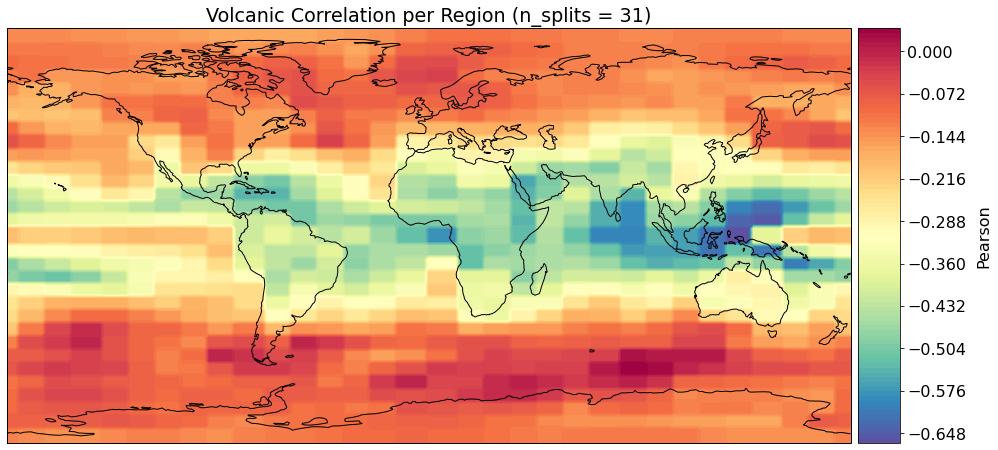

In [9]:
split_index = 30
title = f'Volcanic Correlation per Region (n_splits = {split_index+1})'
fig = plot_map(aod_grid[split_index], title=title, colorbar_title='Pearson')
fig.savefig(path_results / f'map_pearson_volc-{split_index}.png', dpi=300, bbox_inches='tight')
fig

In [10]:
#np.save('../results/volc_mask_pearson.npy', np.min(aod_grid[20]) == aod_grid[20])
#with np.printoptions(threshold=np.inf):
    #print()

In [11]:
interactive_plot(solar_grid)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n_splits:', max=48), Output()),…

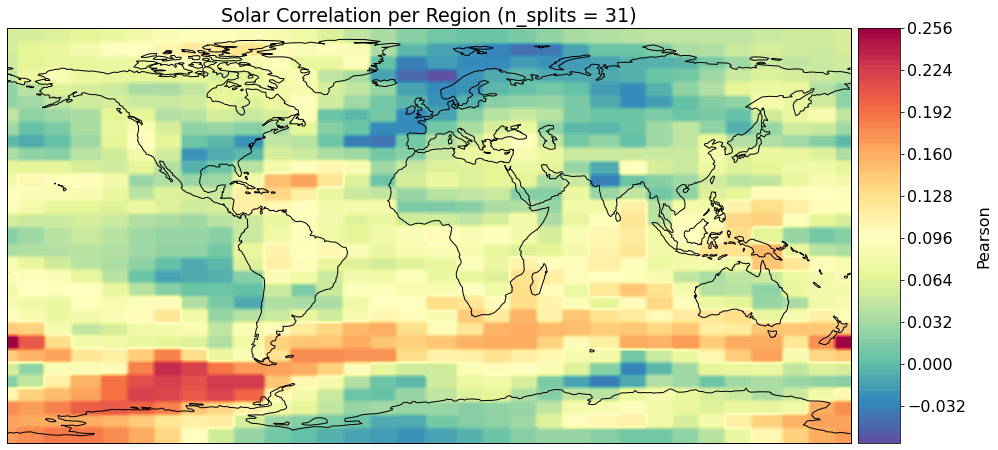

In [12]:
split_index = 30
title = f'Solar Correlation per Region (n_splits = {split_index+1})'
fig = plot_map(solar_grid[split_index], title=title, colorbar_title='Pearson')
fig.savefig(path_results / f'map_pearson_solar-{split_index}.png', dpi=300, bbox_inches='tight')
fig